In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
mat_data = scipy.io.loadmat('Urban_R162.mat')
for key in mat_data:
    print(key)
end=scipy.io.loadmat('end5_groundTruth.mat')
for k in end:
    print(k)

__header__
__version__
__globals__
SlectBands
nRow
nCol
nBand
Y
maxValue
__header__
__version__
__globals__
cood
A
M
nEnd
nRow
nCol


In [2]:
#hyperspectral_data=mat_data['HIM']
t1 = mat_data['nRow']
t2 = mat_data['nCol']
t3 = mat_data['nBand']
t4 = mat_data['Y']
e1=end['cood']
e2=end['A']
e3=end['M']

In [3]:
#print(hyperspectral_data.shape)
print(t1.shape,t1.dtype)
print(t2.shape,t2.dtype)
print(t3.shape,t3.dtype)
print(t4.shape,t4.dtype)

print(e1.shape,e1)
print(e2.shape)
print(e3.shape,e3.dtype)


(1, 1) uint16
(1, 1) uint16
(1, 1) uint8
(162, 94249) uint16
(5, 1) [[array(['1-Asphalt Road'], dtype='<U14')]
 [array(['2-Grass'], dtype='<U7')]
 [array(['3-Tree'], dtype='<U6')]
 [array(['4-Roof'], dtype='<U6')]
 [array(['5-Dirt'], dtype='<U6')]]
(5, 94249)
(162, 5) float64


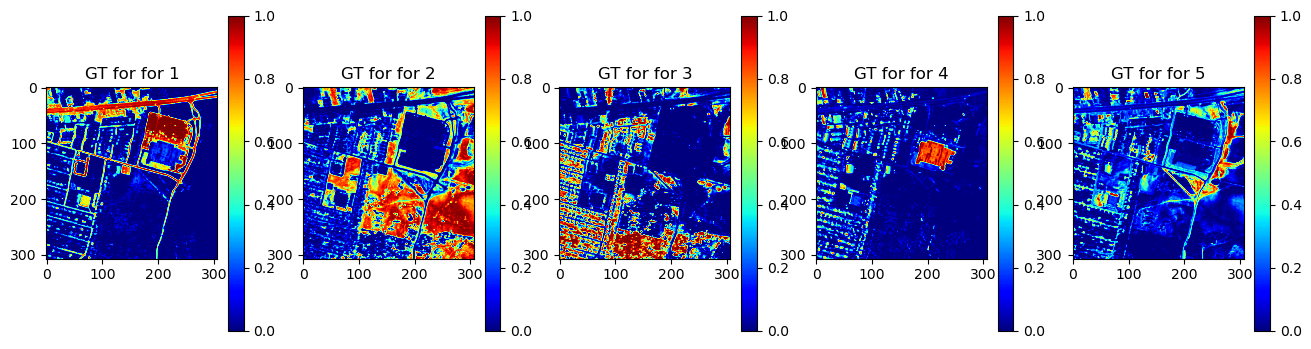

In [6]:


# Assuming 'abundances_gt' is of shape 3x10000
abundances_gt  = e2.reshape((5,307,307))
abundances_gt=np.transpose(abundances_gt, (2,1, 0))

# Display ground truth abundance maps in subplots
num_endmembers = abundances_gt .shape[2]

plt.figure(figsize=(16, 9))

for endmember_index in range(num_endmembers):
    plt.subplot(2, num_endmembers, endmember_index + num_endmembers + 1)
    plt.imshow(abundances_gt [ :, :,endmember_index], cmap='jet', vmin=0, vmax=1)
    plt.title(f'GT for for {endmember_index + 1}')
    plt.colorbar()

plt.show()




In [5]:
synthetic_image_noisy=t4.reshape((162,307,307))
# Reshape the data for the LSTM model
synthetic_image_noisy=np.transpose(synthetic_image_noisy, (2,1, 0))




In [6]:
synthetic_image_noisy = synthetic_image_noisy.reshape((synthetic_image_noisy.shape[0], -1, synthetic_image_noisy.shape[2]))
abundances_gt = abundances_gt.reshape((abundances_gt.shape[0], -1, abundances_gt.shape[2]))
synthetic_image_noisy=synthetic_image_noisy.astype(np.float64)
# Convert to PyTorch tensors
synthetic_image_noisy_tensor = torch.Tensor(synthetic_image_noisy)
#synthetic_image_noisy_tensor = synthetic_image.astype(np.float64)
abundances_gt_tensor = torch.Tensor(abundances_gt)

In [7]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size)
        self.dense = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = self.dense(x)
        return x
# Instantiate the LSTM model
input_size = synthetic_image_noisy.shape[2]
hidden_size = 512
output_size = abundances_gt.shape[2]

lstm_model = LSTMModel(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

# Convert the data to a DataLoader
lstm_dataset = TensorDataset(synthetic_image_noisy_tensor, abundances_gt_tensor)
lstm_loader = DataLoader(lstm_dataset, batch_size=40, shuffle=True)


In [8]:
num_epochs = 50
for epoch in range(num_epochs):
    for inputs, targets in lstm_loader:
        optimizer.zero_grad()
        outputs = lstm_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # Spectral Angle Mapper (SAM) Loss
        normalized_outputs = F.normalize(outputs, p=2, dim=2)
        normalized_targets = F.normalize(targets, p=2, dim=2)
        cos_similarity = F.cosine_similarity(normalized_outputs, normalized_targets, dim=2)
        loss_sam = 1 - cos_similarity.mean()

        # Spectral Information Divergence (SID) Loss
        epsilon = 1e-8
        loss_sid = torch.sum(targets * torch.log((targets + epsilon) / (outputs + epsilon)))

        # Spectral Angle Divergence (SAD) Loss
        sin_similarity = torch.sqrt(1 - cos_similarity**2)
        loss_sad = sin_similarity.mean()
        
        # Root Mean Squared Error (RMSE) Loss
        loss_rmse = torch.sqrt(loss)
        
    # Print the losses at the end of each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], MSE Loss: {loss.item():.4f}, SAM: {loss_sam.item():.6f}, SID: {loss_sid.item():.6f}, SAD: {loss_sad.item():.6f}, RMSE: {loss_rmse.item():.12f}')
# Evaluate the model on the entire dataset
with torch.no_grad():
    predicted_abundances = lstm_model(synthetic_image_noisy_tensor)

Epoch [1/50], MSE Loss: 0.0488, SAM: 0.187474, SID: nan, SAD: 0.543914, RMSE: 0.220969855785
Epoch [2/50], MSE Loss: 0.0223, SAM: 0.086923, SID: nan, SAD: 0.340872, RMSE: 0.149264127016
Epoch [3/50], MSE Loss: 0.0139, SAM: 0.057207, SID: nan, SAD: 0.264623, RMSE: 0.118095330894
Epoch [4/50], MSE Loss: 0.0097, SAM: 0.040912, SID: nan, SAD: 0.218178, RMSE: 0.098317444324
Epoch [5/50], MSE Loss: 0.0062, SAM: 0.026149, SID: nan, SAD: 0.169955, RMSE: 0.078829810023
Epoch [6/50], MSE Loss: 0.0054, SAM: 0.023348, SID: nan, SAD: 0.154922, RMSE: 0.073641702533
Epoch [7/50], MSE Loss: 0.0045, SAM: 0.020541, SID: nan, SAD: 0.139613, RMSE: 0.067328214645
Epoch [8/50], MSE Loss: 0.0039, SAM: 0.016513, SID: nan, SAD: 0.130200, RMSE: 0.062081791461
Epoch [9/50], MSE Loss: 0.0039, SAM: 0.016407, SID: nan, SAD: 0.131449, RMSE: 0.062645003200
Epoch [10/50], MSE Loss: 0.0032, SAM: 0.012516, SID: nan, SAD: 0.115330, RMSE: 0.056572597474
Epoch [11/50], MSE Loss: 0.0030, SAM: 0.012278, SID: nan, SAD: 0.1171

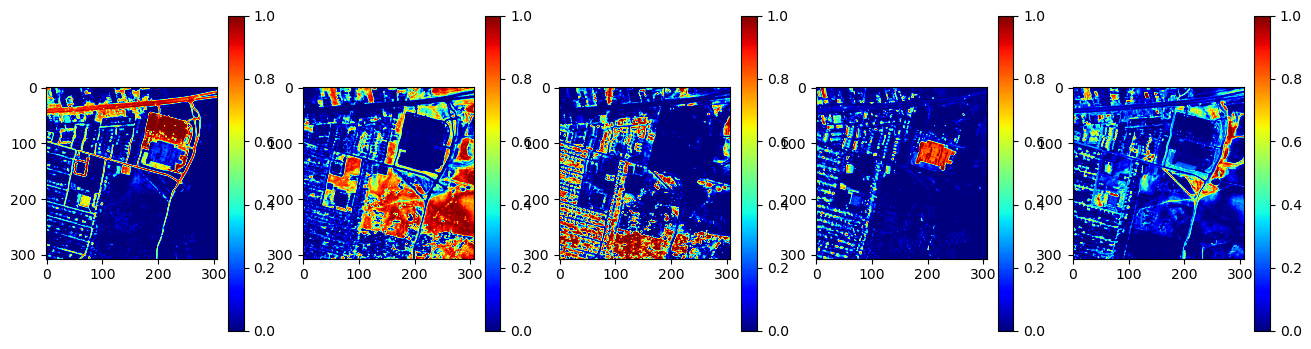

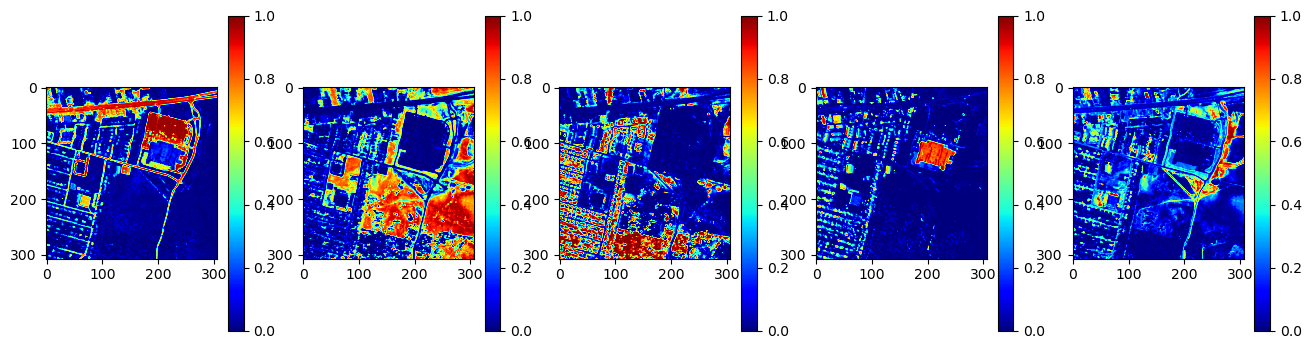

In [9]:


# Assuming 'abundances_gt' is of shape 3x10000
abundances_gt  = e2.reshape((5,307,307))
abundances_gt=np.transpose(abundances_gt, (2,1, 0))

# Display ground truth abundance maps in subplots
num_endmembers = abundances_gt .shape[2]

plt.figure(figsize=(16, 9))

for endmember_index in range(num_endmembers):
    plt.subplot(2, num_endmembers, endmember_index + num_endmembers + 1)
    plt.imshow(abundances_gt [ :, :,endmember_index], cmap='jet', vmin=0, vmax=1)
    #plt.title(f'Ground Truth for {endmember_index + 1}')
    plt.colorbar()

plt.show()


# Assuming 'abundances_gt' is of shape 3x10000
abundances_gt  = e2.reshape((5,307,307))
abundances_gt=np.transpose(abundances_gt, (2,1, 0))

# Display ground truth abundance maps in subplots
num_endmembers = abundances_gt .shape[2]

plt.figure(figsize=(16, 9))

for endmember_index in range(num_endmembers):
    plt.subplot(2, num_endmembers, endmember_index + num_endmembers + 1)
    plt.imshow(predicted_abundances[ :, :,endmember_index], cmap='jet', vmin=0, vmax=1)
    #plt.title(f' Predicted Member {endmember_index + 1}')
    plt.colorbar()

plt.show()